<a href="https://colab.research.google.com/github/ospinooo/mushsnap-research/blob/master/MushSnap_Image_Classification_FineTunning_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Which GPU?
!nvidia-smi

Mon Jun 22 14:19:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q tensorflow-gpu==2.1.0

     |████████████████████████████████| 421.8MB 23kB/s 
     |████████████████████████████████| 450kB 38.7MB/s 
     |████████████████████████████████| 3.9MB 41.1MB/s 
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# TensorFlow version
import tensorflow as tf
print(tf.__version__)

2.1.0


In [6]:
# Other imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os

Using TensorFlow backend.


### Preprocess Data

In [7]:
# Set variables
ZIP_FILENAME_DATASET="mushsnap_dataset_2020-04-20_11-04-43.tar.gz"
DRIVE_PATH= "drive/My Drive/"
TFG_PATH= DRIVE_PATH + "final project"
data_root = "data/data"

In [8]:
# Decompress
!tar -xf drive/'My Drive'/'final project'/dataset/$ZIP_FILENAME_DATASET

In [9]:
# Reading all paths
NUM_MIN = min(len(list(paths.list_images("dataset/edible"))), len(list(paths.list_images("dataset/poisonous"))))
ALL_IMG_PATHS = list(paths.list_images("dataset/edible"))[:NUM_MIN] + list(paths.list_images("dataset/poisonous"))[:NUM_MIN]
ALL_IMG_PATHS = [i for i in ALL_IMG_PATHS if i.split("/")[2][0] != '.']
# Shuffle image paths and preview
random.seed(1)
random.shuffle(ALL_IMG_PATHS)
ALL_IMG_PATHS[:5]
print(f" Total number of images: {len(ALL_IMG_PATHS)}")

 Total number of images: 10729


In [10]:
!rm -rf dataset/inedible

100%|██████████| 50/50 [00:01<00:00, 48.21it/s]


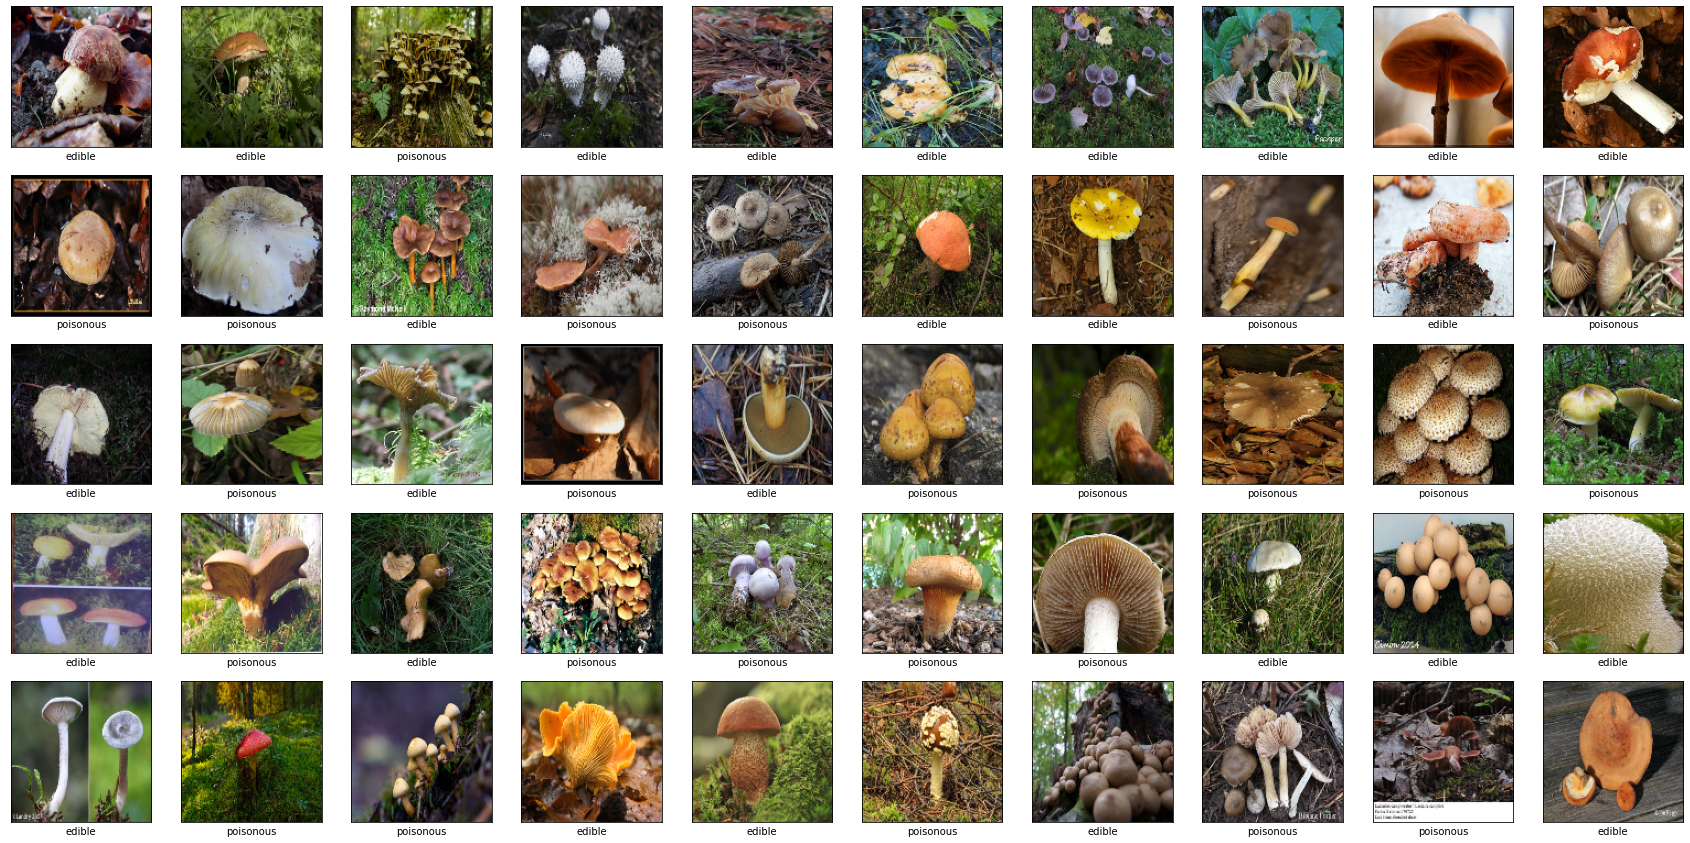

In [12]:
# Visualize images
plt.figure(figsize=(30,15))
for i in tqdm(range(50)):
    image_path = np.random.choice(ALL_IMG_PATHS)
    image = plt.imread(image_path)
    image = cv2.resize(image, (128, 128))
    # you might want to verify the labels before 
    # you put this to use
    label = image_path.split("/")[1]
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

In [13]:
# Split
percentage_test = 0.1
percentage_val = 0.3

# Total images per subset
nb_val_images_i = int(len(ALL_IMG_PATHS) * percentage_val)
nb_test_images_i = int(len(ALL_IMG_PATHS) * percentage_test)
nb_train_images_i = len(ALL_IMG_PATHS) - (nb_val_images_i + nb_test_images_i)

# Create tuples extremes for each subset
nb_train_images = 0, nb_train_images_i
nb_val_images = nb_train_images_i, nb_train_images_i + nb_val_images_i
nb_test_images = nb_train_images_i + nb_val_images_i,  len(ALL_IMG_PATHS)


print(nb_train_images)
print(nb_val_images)
print(nb_test_images)

(0, 6439)
(6439, 9657)
(9657, 10729)


In [14]:
# Specify the directory paths
train_dir = "train"
val_dir = "val"
test_dir = "test"

In [15]:
def move_images(nb_images, output_dir):

    # iterate through the number of images
    for i in tqdm(range(*nb_images)):
        # grab an image path and grab the label of the image
        image_path = ALL_IMG_PATHS[i]
        # careful about the index of the split
        label = image_path.split("/")[1]
        
        # check if a directory for the label exists, if not create it
        new_image_dir = os.path.join(output_dir, label)
        if not os.path.exists(new_image_dir):
            os.makedirs(new_image_dir)
            
        # copy the current image to the respective folder
        shutil.copy2(image_path, new_image_dir)

In [16]:
!rm -rf train
!rm -rf val
!rm -rf test

In [17]:
# Prepare the train and test set
move_images(nb_train_images, train_dir)
move_images(nb_val_images, val_dir)
move_images(nb_test_images, test_dir)

100%|██████████| 1072/1072 [00:00<00:00, 5051.10it/s]


<BarContainer object of 2 artists>

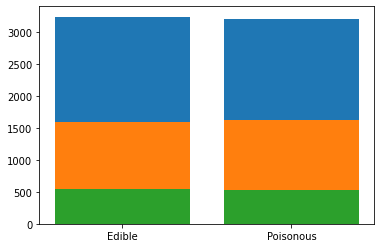

In [18]:
# Plot the sizes of every class

x_labels = ["Edible","Poisonous"]

plt.bar(x_labels, 
        height=[
                len(list(paths.list_images(os.path.join(train_dir, "edible")))),
                len(list(paths.list_images(os.path.join(train_dir, "poisonous"))))
        ])

plt.bar(x_labels, 
        height=[
                len(list(paths.list_images(os.path.join(val_dir, "edible")))),
                len(list(paths.list_images(os.path.join(val_dir, "poisonous"))))
        ])

plt.bar(x_labels, 
        height=[
                len(list(paths.list_images(os.path.join(test_dir, "edible")))),
                len(list(paths.list_images(os.path.join(test_dir, "poisonous"))))
        ])


In [20]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
BATCH_SIZE = 32
CLASS_MODE = "categorical"
# Setup data generators
train_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

val_aug = ImageDataGenerator(
    # rescale=1/255.
    preprocessing_function=preprocess_input
    )

size = (224, 224)

train_gen = train_aug.flow_from_directory("train",
    class_mode=CLASS_MODE,
    target_size=size,
		color_mode="rgb",
		shuffle=True,
		batch_size=BATCH_SIZE
)

val_gen = train_aug.flow_from_directory("val",
    class_mode=CLASS_MODE,
    target_size=size,
		color_mode="rgb",
		shuffle=True,
		batch_size=BATCH_SIZE
)

Found 6439 images belonging to 2 classes.
Found 3218 images belonging to 2 classes.


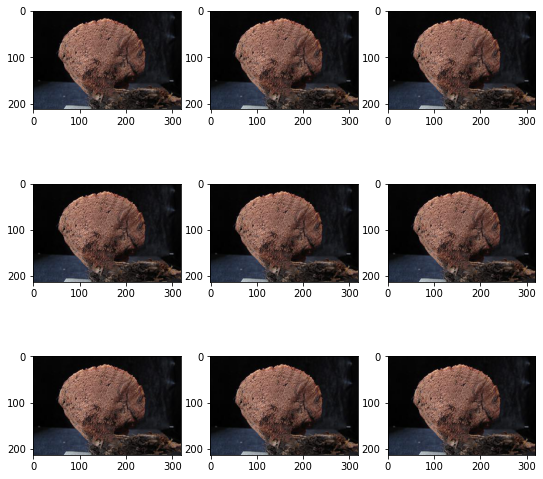

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

!mkdir preview
!rm -rf preview/*

img = load_img(ALL_IMG_PATHS[0])  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in train_aug.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 8:
        break  # otherwise the generator would loop indefinitely

plt.figure(figsize=(9,9))
k = 0
for i in os.listdir('preview'):
    img = plt.imread('preview' + os.sep + i)
    plt.subplot(3,3,k+1)
    k += 1
    plt.imshow(img)

In [22]:
print (train_gen.class_indices)
labels = '\n'.join(sorted(train_gen.class_indices.keys()))
with open('mushroom_labels.txt', 'w') as f:
    f.write(labels)

{'edible': 0, 'poisonous': 1}


In [23]:
!cat mushroom_labels.txt

edible
poisonous

## Training

In [24]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet import ResNet50, ResNet101, ResNet152
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications.nasnet import NASNetLarge, NASNetMobile
from tensorflow.keras.applications.xception import Xception

In [25]:
# Load the model but exclude the classification layers
EXTRACTOR = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

EXTRACTOR.summary()

9412608/9406464 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [26]:
def get_training_model():
    # We are fine-tuning the extractor model
    
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(2, activation="softmax")(class_head)
    
    # Create the new model
    classifier = Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                          optimizer="adagrad",
                          metrics=["accuracy", tf.keras.metrics.Recall()])

    return classifier


### Learning rate

Since we are fine-tuning a pre-trained network it'd be prudent to not break the weights of that pre-trained network too fast. So the idea is to start with a relatively lower learning rate and then increase it gradually.

In [27]:
# LR schedule configuration
start_lr = 0.0001
min_lr = 0.0001
max_lr = 0.001
rampup_epochs = 6
sustain_epochs = 0
exp_decay = .8

In [28]:
# LR schedule
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

0.0001 0.0005608000000000001


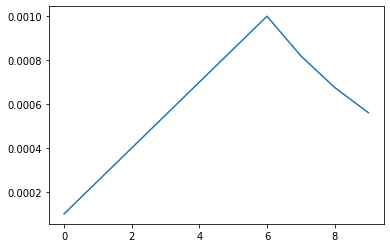

In [29]:
# How does the LR schedule looks like?
rng = [i for i in range(10)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [30]:
n_train_samples = len(list(paths.list_images("train")))
n_val_samples = len(list(paths.list_images("val")))

n_train_samples, n_val_samples

(6439, 3218)

### Training

In [32]:
# Train the model
mushroom_model = get_training_model()

earlystop_callback = EarlyStopping(
  monitor='val_loss',
  patience=10)

start = time.time()
history = mushroom_model.fit(train_gen,
              # steps_per_epoch=n_train_samples//BATCH_SIZE,
              validation_data=val_gen,
              # validation_steps=n_val_samples//BATCH_SIZE,
              epochs=10,
              callbacks=[
                         earlystop_callback,
                         lr_callback])
print("Total training time: ",time.time()-start)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 202 steps, validate for 101 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/10
202/202 [==============================] - 90s 445ms/step - loss: 0.6714 - accuracy: 0.5867 - recall_1: 0.5867 - val_loss: 0.6589 - val_accuracy: 0.6085 - val_recall_1: 0.6085

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 2/10
202/202 [==============================] - 82s 408ms/step - loss: 0.5959 - accuracy: 0.7166 - recall_1: 0.7166 - val_loss: 0.6405 - val_accuracy: 0.6352 - val_recall_1: 0.6352

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00039999999999999996.
Epoch 3/10
202/202 [==============================] - 82s 408ms/step - loss: 0.5372 - accuracy: 0.8115 - recall_1: 0.8115 - val_loss: 0.6270 - val_accuracy: 0.6495 - val_recall_1: 0.6495

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00055.
Epoch 4/10
202/202 [===========================

In [ ]:
mushroom_model.evaluate(val_gen)

In [34]:
MODEL_NAME = f"mobile-net2_9882_6877"

In [35]:
mushroom_model.save(os.path.join(TFG_PATH, f"models/{MODEL_NAME}"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: drive/My Drive/final project/models/mobile-net2_9882_6877/assets


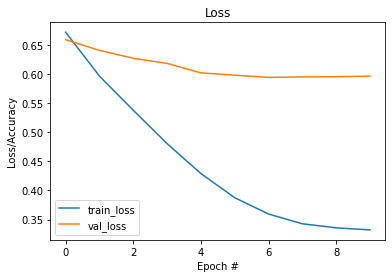

In [36]:
# Plotting the losses
N = len(history.history["loss"])
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

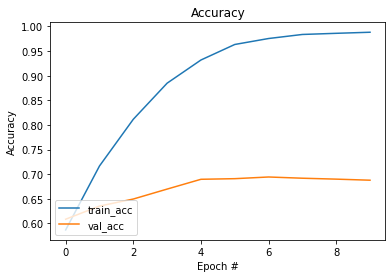

In [37]:
# Plotting the losses
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

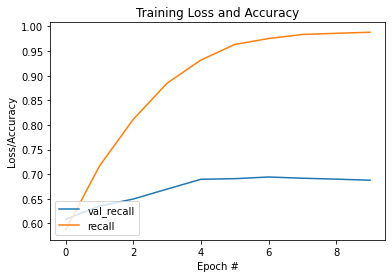

In [40]:
# Plotting the losses
plt.figure()
plt.plot(np.arange(0, N), history.history["val_recall_1"], label="val_recall")
plt.plot(np.arange(0, N), history.history["recall_1"], label="recall")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

## Data augmentation

Now let's use data augmentation.

In [42]:
BATCH_SIZE = 32
CLASS_MODE = "categorical"
# Setup data generators
train_aug = ImageDataGenerator(preprocessing_function=preprocess_input
                               , zoom_range=0.3
                               , rotation_range=40
                               , width_shift_range=0.2
                               , height_shift_range=0.2
                               , shear_range=0.2
                               , horizontal_flip=True
                               , fill_mode='nearest'
                               )

val_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

size = (224, 224)

train_gen = train_aug.flow_from_directory("train",
    class_mode=CLASS_MODE,
    target_size=size,
		color_mode="rgb",
		shuffle=True,
		batch_size=BATCH_SIZE
)

val_gen = train_aug.flow_from_directory("val",
    class_mode=CLASS_MODE,
    target_size=size,
		color_mode="rgb",
		shuffle=True,
		batch_size=BATCH_SIZE
)

Found 6439 images belonging to 2 classes.
Found 3218 images belonging to 2 classes.


In [43]:
# Train the model
mushroom_model = get_training_model()

earlystop_callback = EarlyStopping(
  monitor='val_loss',
  patience=10)

start = time.time()
history = mushroom_model.fit(train_gen,
              # steps_per_epoch=n_train_samples//BATCH_SIZE,
              validation_data=val_gen,
              # validation_steps=n_val_samples//BATCH_SIZE,
              epochs=10,
              callbacks=[
                         earlystop_callback,
                         lr_callback])
print("Total training time: ",time.time()-start)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 202 steps, validate for 101 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/10
202/202 [==============================] - 166s 822ms/step - loss: 0.6481 - accuracy: 0.6274 - recall_2: 0.6274 - val_loss: 0.6419 - val_accuracy: 0.6330 - val_recall_2: 0.6330

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 2/10
202/202 [==============================] - 161s 796ms/step - loss: 0.6096 - accuracy: 0.6763 - recall_2: 0.6763 - val_loss: 0.6296 - val_accuracy: 0.6600 - val_recall_2: 0.6600

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00039999999999999996.
Epoch 3/10
202/202 [==============================] - 161s 795ms/step - loss: 0.5860 - accuracy: 0.7079 - recall_2: 0.7079 - val_loss: 0.6160 - val_accuracy: 0.6582 - val_recall_2: 0.6582

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00055.
Epoch 4/10
202/202 [========================

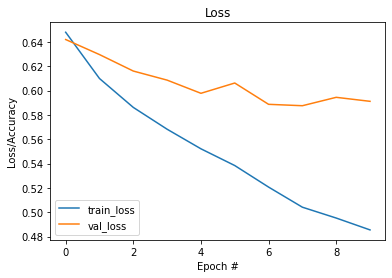

In [59]:
# Plotting the losses
N = len(history.history["loss"])
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

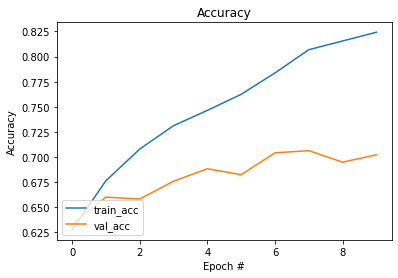

In [60]:
# Plotting the losses
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

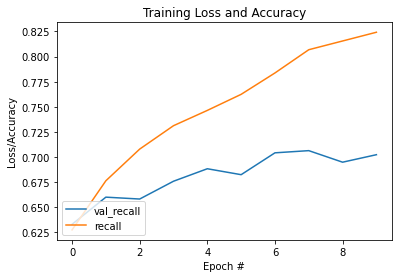

In [57]:
# Plotting the losses
plt.figure()
plt.plot(np.arange(0, N), history.history["val_recall_2"], label="val_recall")
plt.plot(np.arange(0, N), history.history["recall_2"], label="recall")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

### Optimize TFLite

Let's optimize this model with TF Lite in a way it would be compatible with the Edge TPU. To make the model fully int8-quantized, we would need to supply a representative dataset as shown here. It needs the dataset to quantize the weights as well as the activations.

In [44]:
# Extract the image paths from the train set, shuffle them, and 
# choose 100 images
image_paths = list(paths.list_images("train"))
random.shuffle(image_paths)
image_paths = image_paths[:100]

# An empty list as a placeholder for the dataset
rep_ds = []

# Iterate over the image paths
for image in tqdm(image_paths):
    # Read the image from the current path, change the datatype, resize the image,
    # add batch dimension, normalize the pixel values
    image_pixels = plt.imread(image).astype("float32")
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, 0)
    image_pixels = image_pixels / 255.
    
    # Append to the list
    rep_ds.append(image_pixels)

100%|██████████| 100/100 [00:00<00:00, 354.11it/s]


In [45]:
# Convert to TensorFlow dataset
rep_ds = np.array(rep_ds)
rep_ds = tf.data.Dataset.from_tensor_slices((rep_ds))

In [46]:
# Creating a representative dataset for int quantization
def representative_dataset():
    for image in rep_ds.take(100):
        yield [image]

# TF Lite conversion 

In [47]:
# Instantiate the converter, instruct TF Lite to optimize for size, and
# specify the representative dataset
converter = tf.lite.TFLiteConverter.from_keras_model(mushroom_model) 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE] 
converter.representative_dataset = representative_dataset

# We are going for full INT8 quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Convert finally
tflite_model = converter.convert()

In [48]:
# Serialize the TFLite model and check it's size
os.mkdir(os.path.join(DRIVE_PATH,f"tfg/tflite_models/{MODEL_NAME}"))
f = open(os.path.join(DRIVE_PATH,f"tfg/tflite_models/{MODEL_NAME}/{MODEL_NAME}.tflite"), "wb")
f.write(tflite_model)
f.close()

#### Evaluate tflite

In [49]:
# Load the model into interpreters
interpreter_quant = tf.lite.Interpreter(model_content=tflite_model)
interpreter_quant.allocate_tensors()
input_index_quant = interpreter_quant.get_input_details()[0]["index"]
output_index_quant = interpreter_quant.get_output_details()[0]["index"]

In [ ]:
# Prepare validation sets
# Extract the image paths from the train set
image_paths = list(paths.list_images("val"))

# Empty labels for storing images and labels
val_images = []
val_labels = []

# Iterate over the image paths
for image in tqdm(image_paths):
    # Read the image from the current path, change the datatype, resize the image,
    # add batch dimension, normalize the pixel values
    image_pixels = plt.imread(image).astype("float32")
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, 0)
    image_pixels = image_pixels / 255.

    # Extract the label
    label = image.split("/")[1]
    
    # Append to the list
    val_images.append(image_pixels)
    val_labels.append(label)

# Create NumPy array
val_images = np.array(val_images)

In [51]:
# Define the class labels (should be alphabetical)
CLASSES = ['edible', 'poisonous']

100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


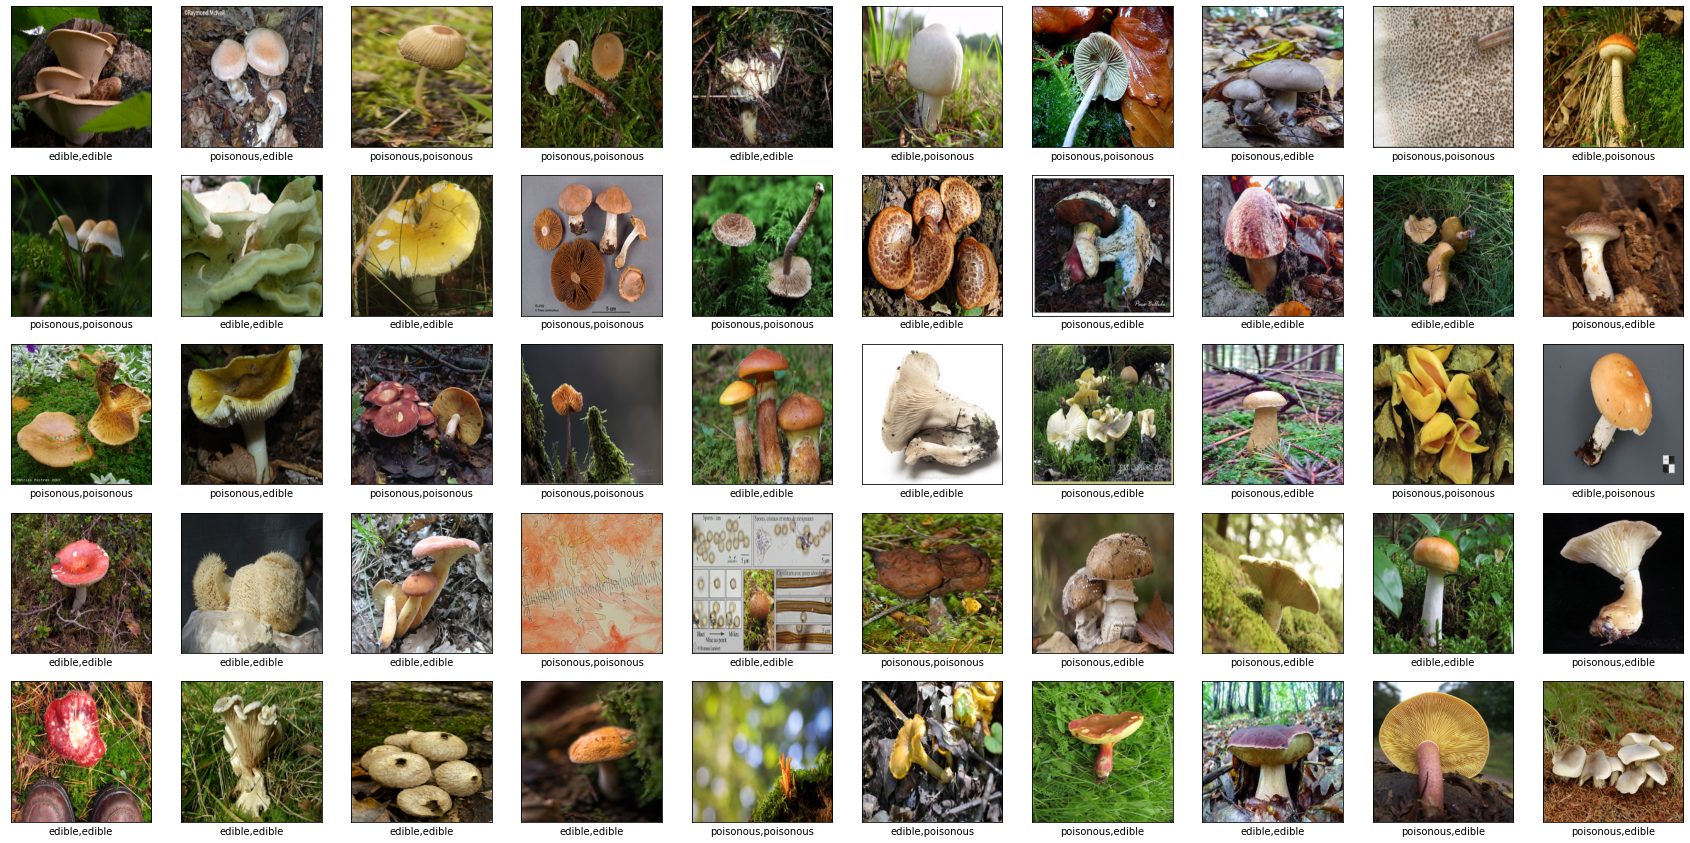

In [52]:
# Run a demo prediction
# Visualize images
plt.figure(figsize=(30,15))
for i in tqdm(range(50)):
    image_idx = np.random.choice(len(val_images))
    label = val_labels[image_idx]
    test_image = val_images[image_idx]

    # Run prediction
    interpreter_quant.set_tensor(input_index_quant, test_image)
    interpreter_quant.invoke()
    predictions = interpreter_quant.get_tensor(output_index_quant)

    # you might want to verify the labels before 
    # you put this to use
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(test_image.squeeze())
    plt.xlabel(f"{label},{str(CLASSES[np.argmax(predictions[0])])}")
plt.show()

### TFLite compiler

In [53]:
%%bash
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
sudo apt-get update
sudo apt-get install edgetpu-compiler

OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,332 B]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:8 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 Packages [1,277 B]
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  16325      0 --:--:-- --:--:-- --:--:-- 16325
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [54]:
OUTPUT_DIR = f"drive/'My Drive'/tfg/tflite_models/{MODEL_NAME}"
PATH = os.path.join(OUTPUT_DIR, MODEL_NAME) + '.tflite' 
!edgetpu_compiler -o $OUTPUT_DIR $PATH

Edge TPU Compiler version 2.1.302470888

Model compiled successfully in 513 ms.

Input model: drive/My Drive/tfg/tflite_models/mobile-net2_9882_6877/mobile-net2_9882_6877.tflite
Input size: 2.71MiB
Output model: drive/My Drive/tfg/tflite_models/mobile-net2_9882_6877/mobile-net2_9882_6877_edgetpu.tflite
Output size: 2.77MiB
On-chip memory used for caching model parameters: 2.71MiB
On-chip memory remaining for caching model parameters: 4.21MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: drive/My Drive/tfg/tflite_models/mobile-net2_9882_6877/mobile-net2_9882_6877_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will